In [227]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

In [228]:
df = pd.read_csv('all_results.csv')
df.head()

,Unnamed: 0,name,algo_name,indices,ratingfrac,userfrac,Unnamed: 0.1,fit_time_all,fit_time_all-like-boycott,fit_time_boycott,...,rmse_all,rmse_all-like-boycott,rmse_boycott,rmse_like-boycott,rmse_non-boycott,test_times_all,test_times_all-like-boycott,test_times_boycott,test_times_like-boycott,test_times_non-boycott
0,0,Under 18 excluded,KNNBaseline_item_msd,NaN,1.0,0.5,0000_KNNBaseline_item_msd,15.369191,15.369191,15.369191,...,0.887211,1.037459,1.114452,0.975736,0.884181,72.178317,147.016764,145.116230,146.157918,143.804212
1,1,Under 18 excluded,SVD,NaN,1.0,0.5,0000_SVD,50.034708,50.034708,50.034708,...,0.876733,1.050087,1.146766,0.973409,0.873110,5.351329,13.862198,13.738694,13.788180,12.382417
2,2,18-24 excluded,KNNBaseline_item_msd,NaN,1.0,0.5,0001_KNNBaseline_item_msd,14.830245,14.830245,14.830245,...,0.897247,0.980092,1.024963,0.932439,0.883220,67.848187,145.769697,134.199337,139.798115,132.662584
3,3,18-24 excluded,SVD,NaN,1.0,0.5,0001_SVD,46.507224,46.507224,46.507224,...,0.887710,0.969206,1.024393,0.907940,0.872343,8.074041,18.028050,16.748750,17.024271,14.578683
4,4,25-34 excluded,KNNBaseline_item_msd,NaN,1.0,0.5,0002_KNNBaseline_item_msd,12.761534,12.761534,12.761534,...,0.905881,0.929651,0.979513,0.881714,0.887886,67.996376,169.768699,135.248222,151.481311,132.072707


In [229]:
samples_df = df[df.name.str.contains('sample')]
samples_df.head()

,Unnamed: 0,name,algo_name,indices,ratingfrac,userfrac,Unnamed: 0.1,fit_time_all,fit_time_all-like-boycott,fit_time_boycott,...,rmse_all,rmse_all-like-boycott,rmse_boycott,rmse_like-boycott,rmse_non-boycott,test_times_all,test_times_all-like-boycott,test_times_boycott,test_times_like-boycott,test_times_non-boycott
264,0,1 user sample,KNNBaseline_item_msd,251-to-500,1.0,1.0,0000_KNNBaseline_item_msd,26.288869,26.288869,26.288869,...,0.885193,0.910631,0.910631,NaN,0.885191,119.741490,239.433852,239.432995,NaN,237.743915
265,1,1 user sample,SVD,251-to-500,1.0,1.0,0000_SVD,77.254085,77.254085,77.254085,...,0.873856,0.911339,0.911339,NaN,0.873853,25.991666,50.700684,50.699503,NaN,48.803505
266,2,1 user sample,KNNBaseline_item_msd,251-to-500,1.0,1.0,0001_KNNBaseline_item_msd,24.866848,24.866848,24.866848,...,0.885336,0.837813,0.837813,NaN,0.885337,119.285849,237.998275,237.997447,NaN,236.306477
267,3,1 user sample,SVD,251-to-500,1.0,1.0,0001_SVD,75.730098,75.730098,75.730098,...,0.873730,0.865301,0.865301,NaN,0.873729,26.786353,49.340827,49.339908,NaN,47.432520
268,4,1 user sample,KNNBaseline_item_msd,251-to-500,1.0,1.0,0002_KNNBaseline_item_msd,24.796413,24.796413,24.796413,...,0.885275,0.595576,0.595576,NaN,0.885340,119.889587,239.538891,239.537447,NaN,237.819864


In [230]:
list(samples_df.columns.values)

['Unnamed: 0',
 'name',
 'algo_name',
 'indices',
 'ratingfrac',
 'userfrac',
 'Unnamed: 0.1',
 'fit_time_all',
 'fit_time_all-like-boycott',
 'fit_time_boycott',
 'fit_time_like-boycott',
 'fit_time_non-boycott',
 'increase_mae_all',
 'increase_mae_all-like-boycott',
 'increase_mae_boycott',
 'increase_mae_like-boycott',
 'increase_mae_non-boycott',
 'increase_ndcg10_all',
 'increase_ndcg10_all-like-boycott',
 'increase_ndcg10_boycott',
 'increase_ndcg10_like-boycott',
 'increase_ndcg10_non-boycott',
 'increase_ndcg5_all',
 'increase_ndcg5_all-like-boycott',
 'increase_ndcg5_boycott',
 'increase_ndcg5_like-boycott',
 'increase_ndcg5_non-boycott',
 'increase_ndcgfull_all',
 'increase_ndcgfull_all-like-boycott',
 'increase_ndcgfull_boycott',
 'increase_ndcgfull_like-boycott',
 'increase_ndcgfull_non-boycott',
 'increase_prec10t4_all',
 'increase_prec10t4_all-like-boycott',
 'increase_prec10t4_boycott',
 'increase_prec10t4_like-boycott',
 'increase_prec10t4_non-boycott',
 'increase_prec5

In [298]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac']
metrics = ['rmse', 'ndcg10', 'prec10']

In [307]:
def select_cols(cols, metrics, groups, percents):
    """ rename?"""
    increase_cols = [
        x for x in cols if any(metric in x for metric in metrics)
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    return increase_cols

In [308]:
# grouped factor plot
def plot1(df, metrics, groups, percents=False):
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = longform.assign(
        metric=[x.split('_')[-2] for x in longform.increase_type]
    )
    longform = longform.assign(
        group=[x.split('_')[-1] for x in longform.increase_type]
    )
    print(longform.head())
    names = list(set(df.name))
    names = sorted(names, key = lambda x: int(''.join([s for s in x.split() if s.isdigit()])))
    print(names)
    g = sns.factorplot(
        x="name", y="value", hue="group", data=longform,
        size=6, kind="point", col='algo_name', row='metric',
        # xticks=[1,2,3,4,5,6,7,8],
        order=names
    )
    if percents:
        g.set_ylabels("percent increase")
    else:
        g.set_ylabels("increase")
    g.set_xticklabels(["0.01%", "0.05%", "0.1%", "0.5%", "1%", "5%", "10%", "50%",])
    g.set_xlabels('Percent of Users')
    return g


            name             algo_name     indices  ratingfrac  userfrac  \
0  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   
1  1 user sample                   SVD  251-to-500         1.0       1.0   
2  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   
3  1 user sample                   SVD  251-to-500         1.0       1.0   
4  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   

                 increase_type     value  metric group  
0  percent_increase_ndcg10_all  0.048378  ndcg10   all  
1  percent_increase_ndcg10_all  0.229382  ndcg10   all  
2  percent_increase_ndcg10_all  0.004556  ndcg10   all  
3  percent_increase_ndcg10_all  0.281903  ndcg10   all  
4  percent_increase_ndcg10_all  0.070724  ndcg10   all  
['1 user sample', '3 user sample', '6 user sample', '30 user sample', '60 user sample', '302 user sample', '604 user sample', '3020 user sample']


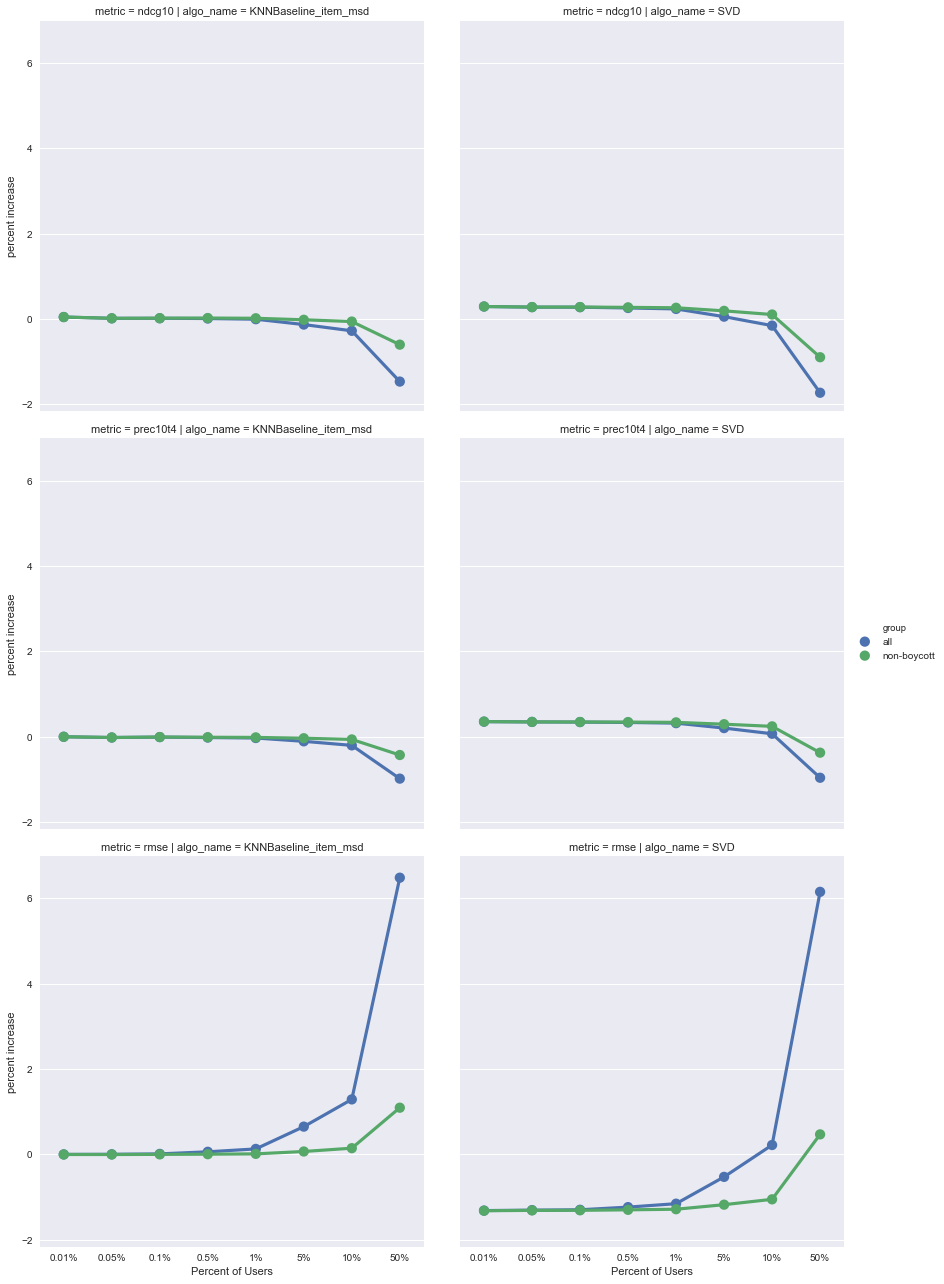

In [309]:
g = plot1(
    samples_df,
    metrics=metrics,
    percents=True,
    groups=['non-boycott', 'all',]
)
plt.show()

            name             algo_name     indices  ratingfrac  userfrac  \
0  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   
1  1 user sample                   SVD  251-to-500         1.0       1.0   
2  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   
3  1 user sample                   SVD  251-to-500         1.0       1.0   
4  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   

         increase_type     value  metric group  
0  increase_ndcg10_all  0.000383  ndcg10   all  
1  increase_ndcg10_all  0.001815  ndcg10   all  
2  increase_ndcg10_all  0.000036  ndcg10   all  
3  increase_ndcg10_all  0.002231  ndcg10   all  
4  increase_ndcg10_all  0.000560  ndcg10   all  
['1 user sample', '3 user sample', '6 user sample', '30 user sample', '60 user sample', '302 user sample', '604 user sample', '3020 user sample']


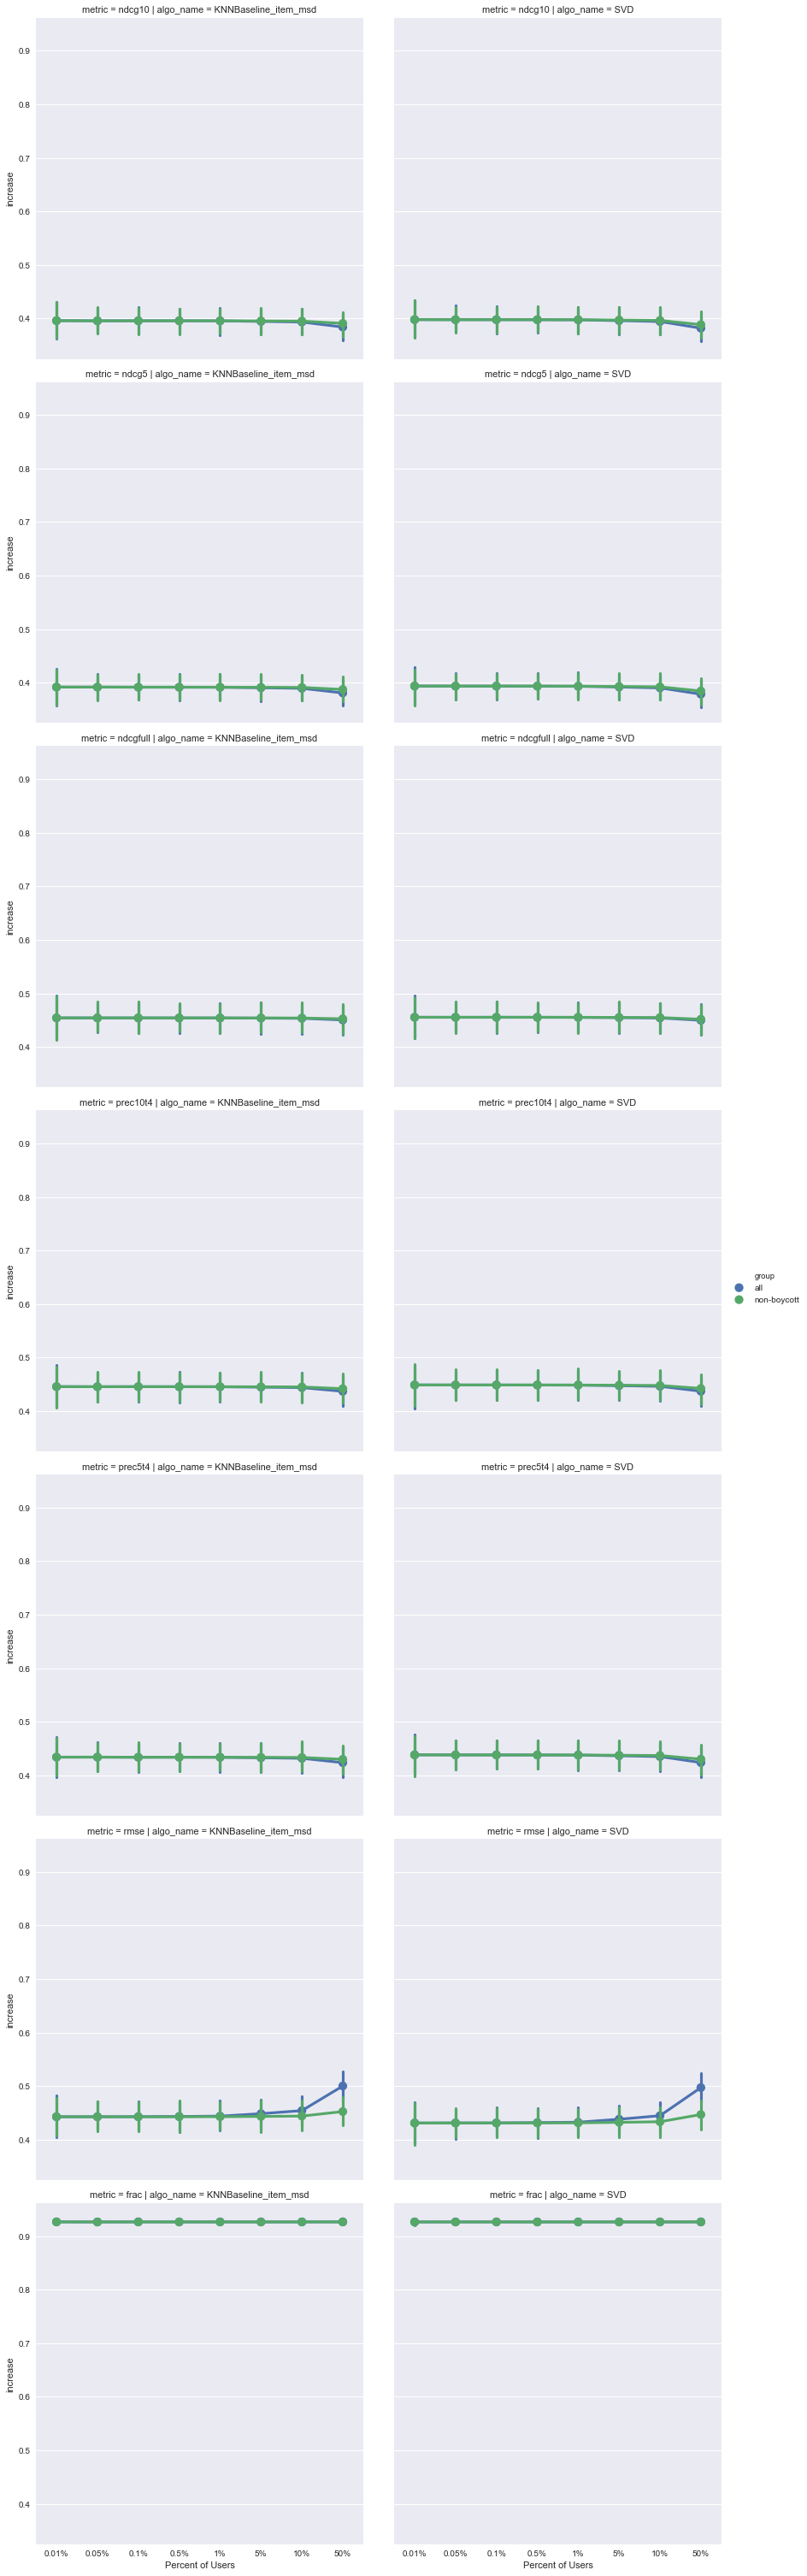

In [271]:
g = plot1(
    samples_df,
    metrics=['rmse', 'ndcg', 'prec'],
    percents=False,
    groups=['non-boycott', 'all',]
)
plt.show()

In [348]:
# organized_df = df[~df.name.str.contains('sample')]
# list(set(organized_df.name))

In [342]:
def plot2(df, metrics, groups, percents=False):
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = longform.assign(
        metric=[x.split('_')[-2] for x in longform.increase_type]
    )
    longform = longform.assign(
        group=[x.split('_')[-1] for x in longform.increase_type]
    )
    print(longform.head())
    
    g = sns.factorplot(
        x="value", y="name", hue="group", data=longform,
        size=10, kind="point", col='algo_name', row='metric',
        sharex=False,
        linestyles='None',
        capsize=0.1
    )

In [ ]:
state_boycotts = organized_df[organized_df.name.str.contains('state')]

                              name             algo_name indices  ratingfrac  \
0  users from state US_AZ excluded  KNNBaseline_item_msd     NaN         1.0   
1  users from state US_AZ excluded                   SVD     NaN         1.0   
2  users from state US_MI excluded  KNNBaseline_item_msd     NaN         1.0   
3  users from state US_MI excluded                   SVD     NaN         1.0   
4  users from state US_NY excluded  KNNBaseline_item_msd     NaN         1.0   

   userfrac                        increase_type     value  metric  \
0       1.0  percent_increase_ndcg10_non-boycott  0.081404  ndcg10   
1       1.0  percent_increase_ndcg10_non-boycott  0.255244  ndcg10   
2       1.0  percent_increase_ndcg10_non-boycott -0.056026  ndcg10   
3       1.0  percent_increase_ndcg10_non-boycott  0.242112  ndcg10   
4       1.0  percent_increase_ndcg10_non-boycott -0.060048  ndcg10   

         group  
0  non-boycott  
1  non-boycott  
2  non-boycott  
3  non-boycott  
4  non-boycot

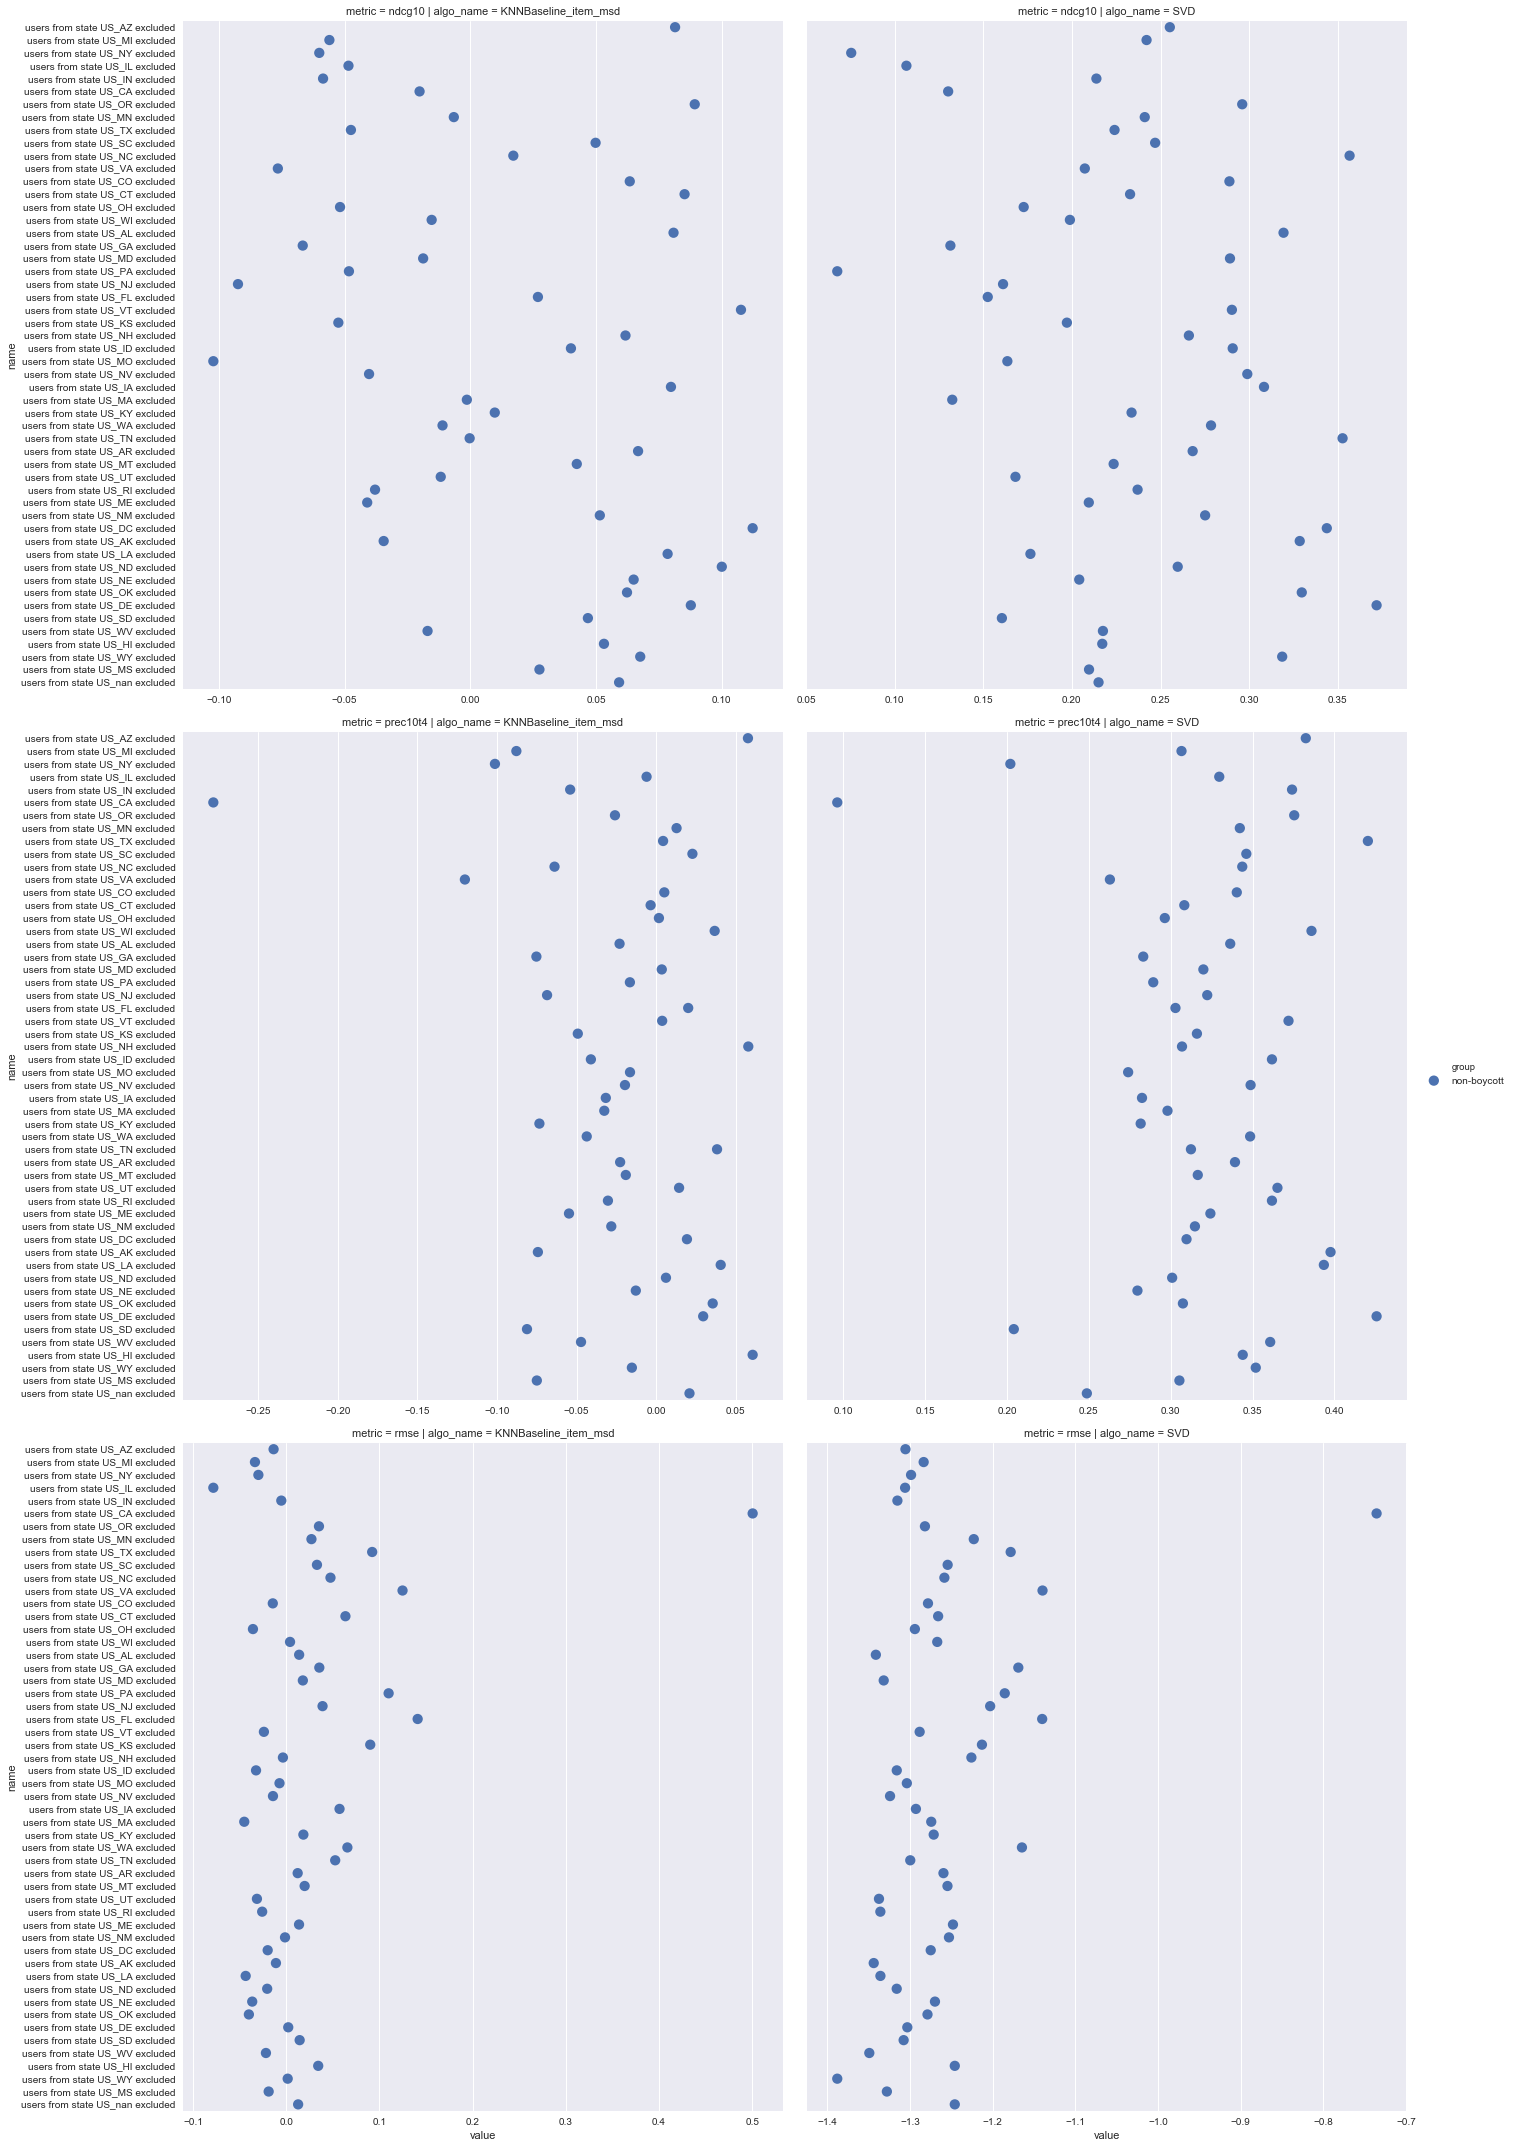

In [349]:
plot2(
    state_boycotts[((state_boycotts.userfrac == 1.0) & (state_boycotts.ratingfrac == 1.0))],
    metrics=metrics,
    percents=True,
    groups=['non-boycott',]
)
plt.show()

In [ ]:
plot2(
    state_boycotts[((state_boycotts.userfrac == 1.0) & (state_boycotts.ratingfrac == 1.0))],
    metrics=metrics,
    percents=False,
    groups=['non-boycott',]
)
plt.show()

                              name             algo_name indices  ratingfrac  \
0  users from state US_AZ excluded  KNNBaseline_item_msd     NaN         1.0   
1  users from state US_AZ excluded                   SVD     NaN         1.0   
2  users from state US_MI excluded  KNNBaseline_item_msd     NaN         1.0   
3  users from state US_MI excluded                   SVD     NaN         1.0   
4  users from state US_NY excluded  KNNBaseline_item_msd     NaN         1.0   

   userfrac                increase_type     value  metric        group  
0       1.0  increase_ndcg10_non-boycott  0.000644  ndcg10  non-boycott  
1       1.0  increase_ndcg10_non-boycott  0.002020  ndcg10  non-boycott  
2       1.0  increase_ndcg10_non-boycott -0.000443  ndcg10  non-boycott  
3       1.0  increase_ndcg10_non-boycott  0.001916  ndcg10  non-boycott  
4       1.0  increase_ndcg10_non-boycott -0.000475  ndcg10  non-boycott  


                    name             algo_name indices  ratingfrac  userfrac  \
0    male users excluded  KNNBaseline_item_msd     NaN         1.0       0.5   
1    male users excluded                   SVD     NaN         1.0       0.5   
2  female users excluded  KNNBaseline_item_msd     NaN         1.0       0.5   
3  female users excluded                   SVD     NaN         1.0       0.5   
4    male users excluded  KNNBaseline_item_msd     NaN         0.5       1.0   

                 increase_type     value  metric group  
0  percent_increase_ndcg10_all -1.223428  ndcg10   all  
1  percent_increase_ndcg10_all -1.268019  ndcg10   all  
2  percent_increase_ndcg10_all -0.371302  ndcg10   all  
3  percent_increase_ndcg10_all -0.229438  ndcg10   all  
4  percent_increase_ndcg10_all -1.349792  ndcg10   all  


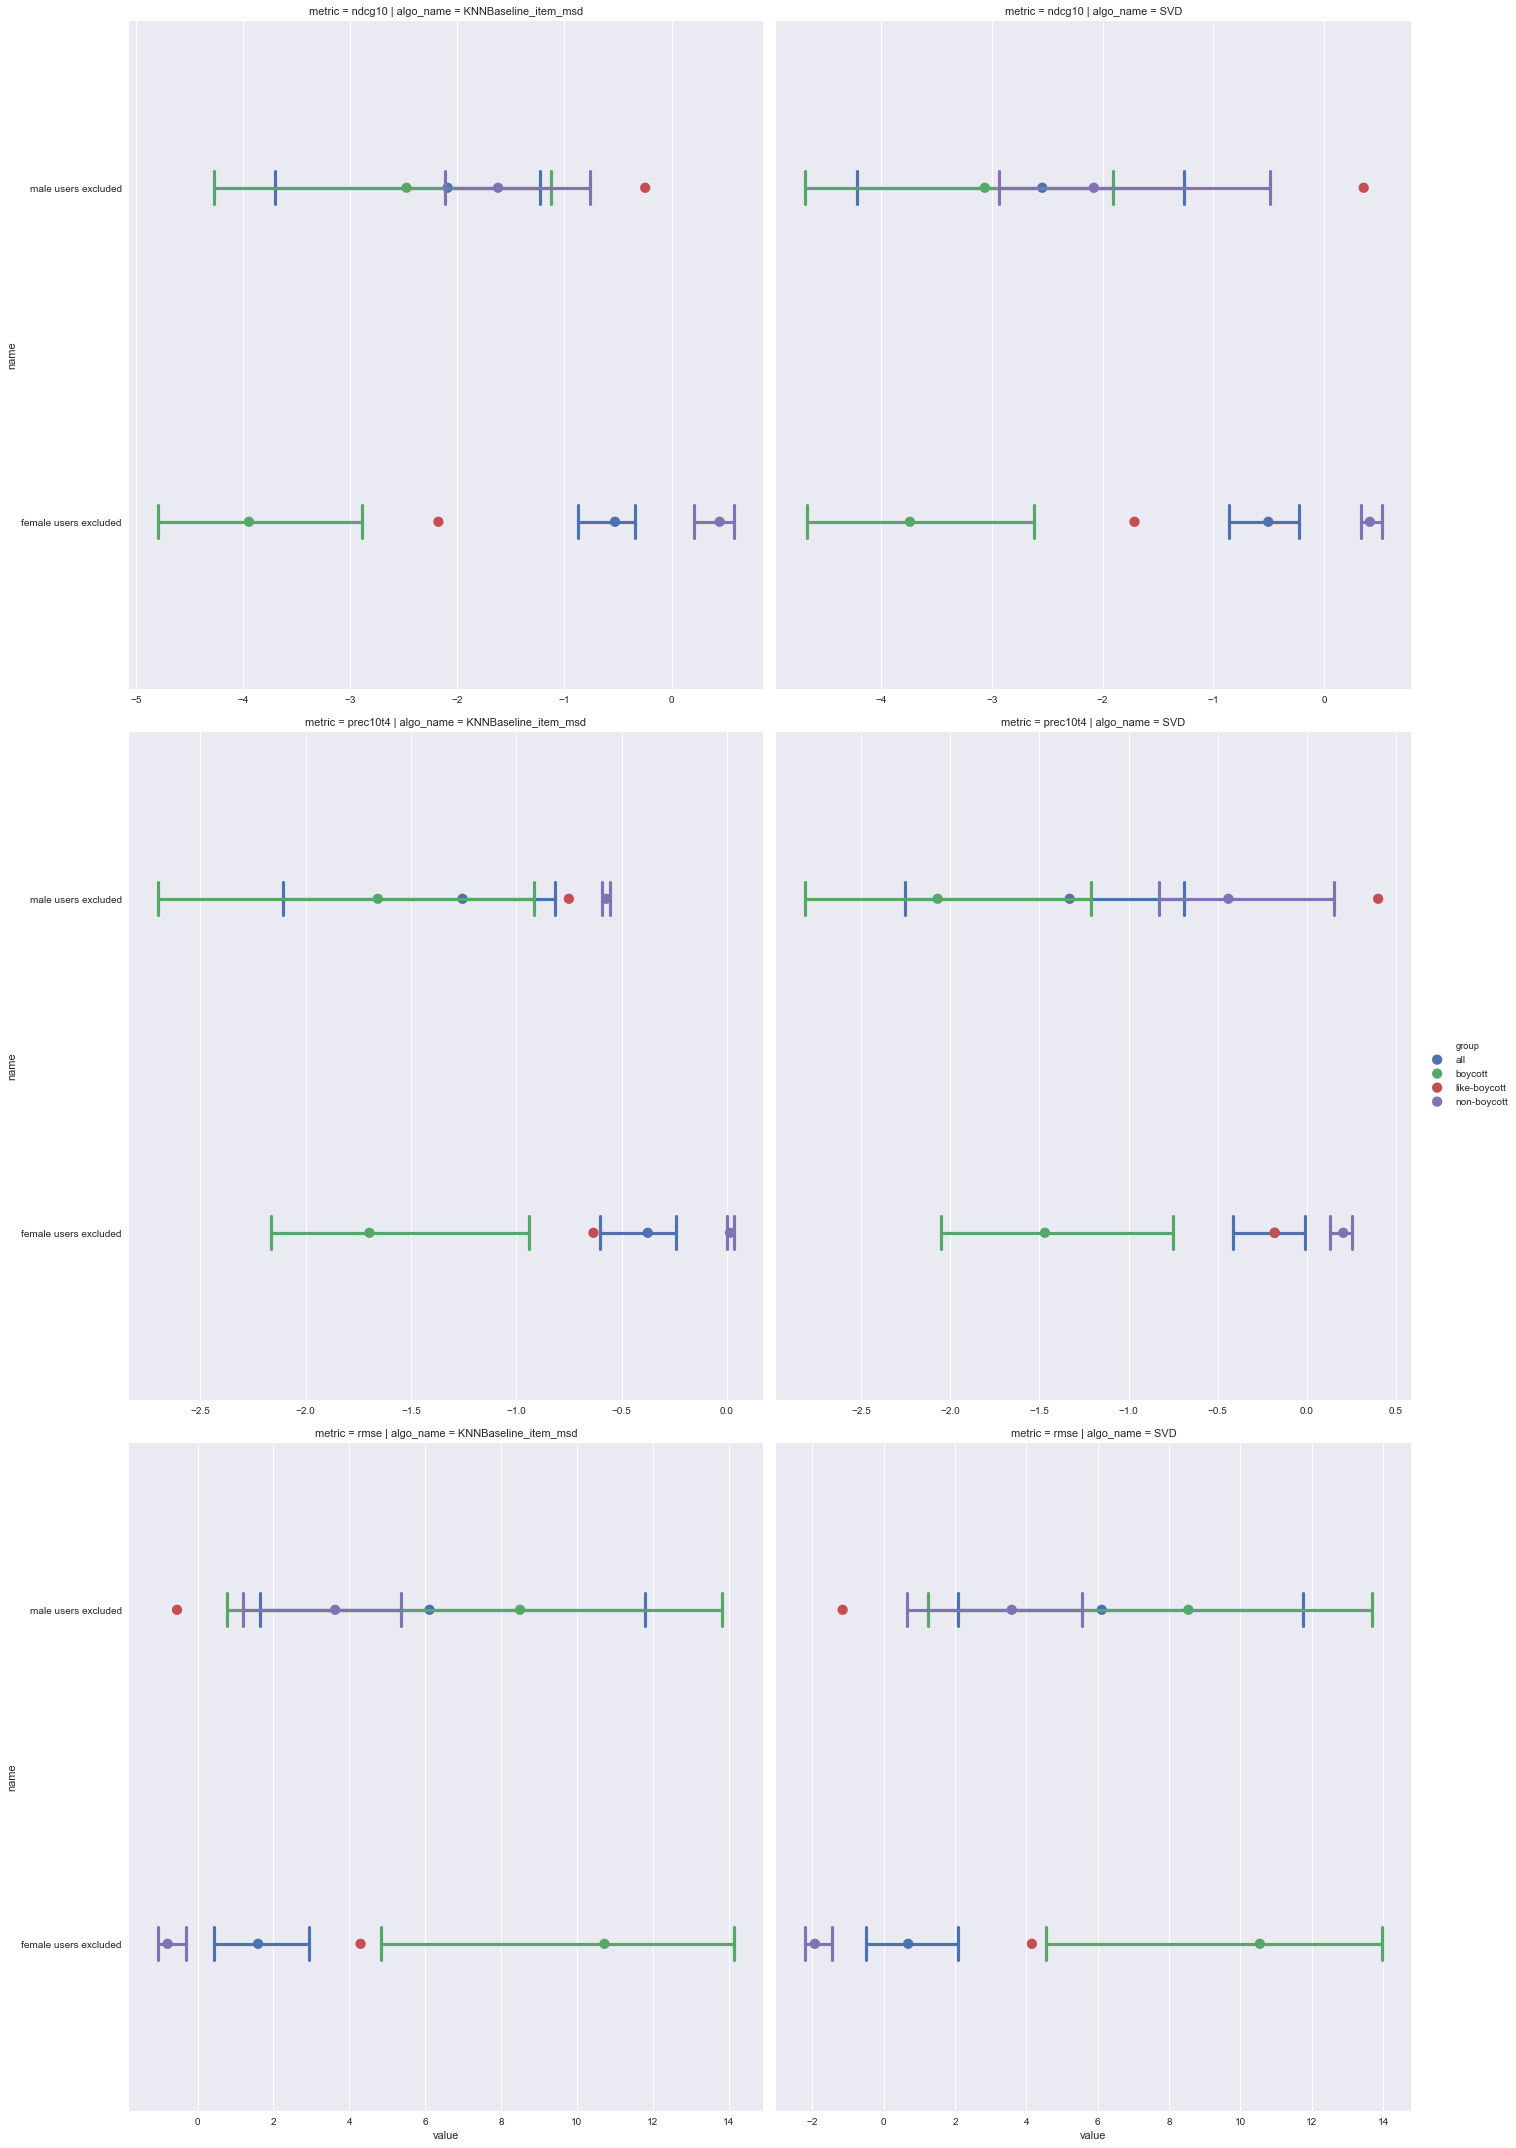

In [343]:
# flag. not a great way to filter the data.
gender_df = organized_df[(organized_df.name.str.contains('male') | organized_df.name.str.contains('female'))]
plot2(
    gender_df,
    metrics=metrics,
    percents=True,
    groups=['non-boycott', 'all', 'boycott', 'like-boycott']
)
plt.show()